# Part 2. Propensity Score Matching

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import seaborn as sns
from scipy import stats
import shap
#!pip install xgboost
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import StratifiedKFold
from scipy.stats import ttest_ind
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV

from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt

%matplotlib inline

In [16]:
file_path_2020 = '2020_survey_data_cleansed.csv'
df = pd.read_csv(file_path_2020)
df.head()

,RES_AGE,RES_SEX,B1,B3,B4,B4_1_etc,B5_1_etc_1,B5_1_etc_2,B5_2_etc_1,B5_2_etc_2,...,D14_SUM,H3_SUM,H4_SUM,H13_SUM,H14_1_SUM,H16_SUM,E5,J3b_1_13,J3b_1_1,E1_3_1
0,67,2,2,2,1,1,0,0,0,0,...,0,30,17,0,0,18.28062,1,1789,1020,1
1,68,2,2,2,1,2,0,0,1,7,...,2,30,17,0,0,15.13697,1,1389,324,0
2,66,2,2,1,1,1,0,0,1,3,...,0,15,21,0,0,18.00000,1,2180,1500,0
3,66,1,2,1,1,1,0,0,0,0,...,0,15,18,0,0,17.00000,0,3100,2300,0
4,68,2,3,4,1,1,0,0,1,3,...,3,16,20,0,0,23.13697,1,719,324,1


features 묶음은 아래와 같습니다
1. 건강상태 관련
 - health_essential
 - health_raw
 - health_compound
2. 가족/사회관계 관련
 - social_essential
 - social_raw
 - social_compound
3. 노후생활 관련
 - life_essential
 - life_raw
 - life_compound

In [17]:
# health-related features
health_essential = ['RES_AGE','RES_SEX','B1','B3','B4','B4_1_etc','B5_1_etc_1','B5_1_etc_2','B5_2_etc_1','B5_2_etc_2','B7','B8','B8_1a','B9','C4','C10_1_2','I1x1']
health_raw = ['B2_2L_1','B2_2L_2','B2_2L_3','B2_2L_4','B2_2L_5','B2_2L_6','B2_2L_7','B2_2L_8','B2_2L_9','B2_2L_10','B2_2L_11','B2_2L_12','B2_2L_13','B2_2L_14','B2_2L_15','B2_2L_16','B2_2L_17','B2_2L_18','B2_2L_19','B2_2L_20','B2_2L_21','B2_2L_22','B2_2L_23','B2_2L_24','B2_2L_25','B2_2L_26','B2_2L_27','B2_2L_28','B2_2L_29','B2_2L_30','B2_2L_31','B2_2L_32',
              'B6_1','B6_2','B6_3','B6_4','B6_5','B6_6','B6_7','B6_8','B6_9','B6_10','B6_11','B6_12','B6_13','B6_14','B6_15',
              'B9_1a','B9_2a',
              'B10_1','B10_3',
              'B11_1','B11_2','B11_3_1','B11_3_2','B11_3_3','B11_4','B11_5','B11_6','B11_7','B11_8','B11_9','B11_10',
              'C1_1','C2_1','C3_1',
              'C1_2','C2_2','C3_2',
              'C5_1','C5_2','C5_3','C5_4','C5_5','C5_6',
              'C6_1','C6_2','C6_3','C6_4','C6_5','C6_6','C6_7',
              'C7_1_1','C7_1_2','C7_1_3','C7_1_4','C7_1_5','C7_1_6','C7_1_7',
              'C7_2_8','C7_2_9','C7_2_10',
             ]
health_compound = ['B2_3','B6_SUM','B9_3a','B10_BMI','B11_SUM','C_SUM_1','C_SUM_2','C5_SUM','C_6_7_SUM']
health_features_1 = health_essential + health_raw
health_features_2 = health_essential + health_compound

# social-related features
social_essential = ['EDM','S5_1','S5_2','S6_1','S6_2','S6_3','S6_4','S6_5','F1_1_2_1','F1_1_2_2','F1_1_3_1','F1_1_3_2','F2','F2_1','F5_1_etc','F5_1','F5_2','G4_1','F6','F13_1_etc','F14','F14_1','F15','F15_1','F16_1','F16_2','AREA_11','AREA_21','AREA_22','AREA_23','AREA_24','AREA_25','AREA_26','AREA_29','AREA_31','AREA_32','AREA_33','AREA_34','AREA_35','AREA_36','AREA_37','AREA_38','AREA_39']
social_raw = ['G1_4_7','G1_4_8','G1_4_9','G1_4_10','G1_4_11','G1_4_12','G2_4_7','G2_4_8','G2_4_9','G2_4_10','G2_4_11','G2_4_12','G3_4_7','G3_4_8','G3_4_9','G3_4_10','G3_4_11','G3_4_12']
social_compound = ['G1_4_AGG','G2_4_AGG','G3_4_AGG']
social_features_1 = social_essential + social_raw
social_features_2 = social_essential + social_compound

# life-quality-related features
life_essential = ['D1_1_etc','D2','D3','D6_1_1','D6_1_2','D6_1_3','D8_1','H1_1','H1_2','H1_3','H1_4','H1_5','H2','H11','H12_1_etc','H15','H18','H25']
life_raw = ['D5_3_1','D5_3_2','D7_3_1','D7_3_2','D11_2_1','D11_2_2','D11_2_3','D11_2_4','D11_2_5','D11_2_6',
'D13_1','D13_2','D13_3','D13_4','D13_5','D13_6','D13_7','D13_8','D13_9','D13_10','D13_11',
'D14_1','D14_2','D14_3',
'H3_1','H3_2','H3_3','H3_4','H3_5','H3_6','H3_7',
'H4_1','H4_2','H4_3','H4_4','H4_5','H4_6','H4_7',
'H13_1','H13_2','H13_3','H13_4','H13_5','H13_6',
'H14_1_1','H14_1_2','H14_1_3','H14_1_4','H14_1_5','H14_1_6',
'H16_1','H16_2','H16_3','H16_4','H16_5','H16_6','H16_7']
life_compound = ['D5_3_3','D7_3_3','D11_2_SUM','D13_SUM','D14_SUM','H3_SUM','H4_SUM','H13_SUM','H14_1_SUM','H16_SUM']
life_features_1 = life_essential + life_raw
life_features_2 = life_essential + life_compound

# 1. Treatment T

여기서 treatment는 정부 지원 일자리 프로그램 참여여부입니다.

컬럼 이름은 **E1_3_1**이며 0(참여하지 않음)과 1(참여함), 두가지 값을 받고 있습니다.

분포도는 아래와 같습니다.

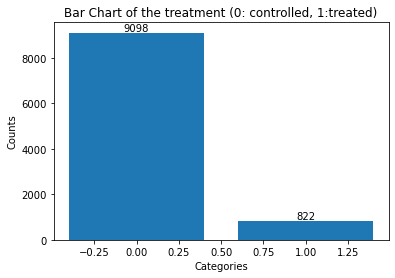

In [18]:
values = df['E1_3_1'].value_counts()
labels = values.index
plt.figure(figsize=(6,4))
bars = plt.bar(labels, values)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')
plt.title('Bar Chart of the treatment (0: controlled, 1:treated)')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

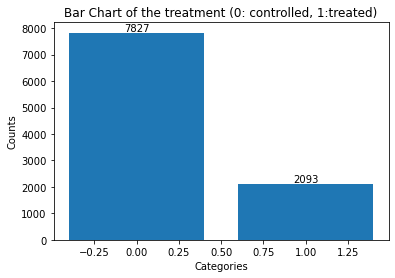

In [19]:
values = df['E5'].value_counts()
labels = values.index
plt.figure(figsize=(6,4))
bars = plt.bar(labels, values)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')
plt.title('Bar Chart of the treatment (0: controlled, 1:treated)')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

# 2. Matching

분석을 위한 데이터가 필요합니다. 현재 우리는 노인 일자리 정책에 참여하고 있는 데이터 800개가 있으며, TE를 구하기 위해 참여하고 있지 않은 집단의 데이터가 필요합니다. 

우리는 아래와 같은 조건을 만족하는 데이터를 찾습니다:
- 참여의향이 있음 (df[E5]==1).
- 현재 참여중이지 않음.


고로, 일단 참여의향에 따른 분포를 그려보았습니다:

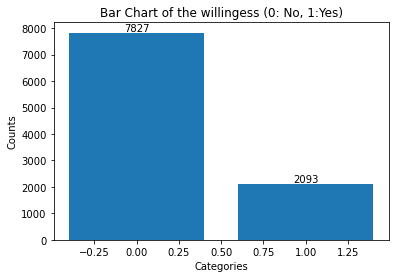

In [20]:
values = df['E5'].value_counts()
labels = values.index
plt.figure(figsize=(6,4))
bars = plt.bar(labels, values)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')
plt.title('Bar Chart of the willingess (0: No, 1:Yes)')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

위와 같이 나와있듯, 약 2000여명이 참여의향이 있다고 나왔습니다. 현재 참여 중인 800명이 모두 참여의향이 있다는 극단적인 가정을 해도 약 1200명이 남습니다. 꽤 충분한 숫자입니다.

그래서 이 참여의향이 있는 2000여명 중 현재 정부지원일자리 정책에 참여여부의 분포를 그려봤습니다.

In [21]:
df_willing = df[df['E5']==1]

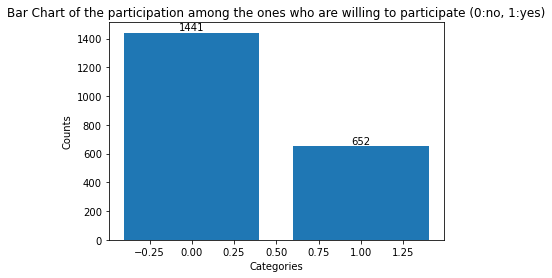

In [22]:
values = df_willing['E1_3_1'].value_counts()
labels = values.index
plt.figure(figsize=(6,4))
bars = plt.bar(labels, values)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')
plt.title('Bar Chart of the participation among the ones who are willing to participate (0:no, 1:yes)')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

위와 같이 나와있듯, 참여의향이 있는 사람들 중, 현재 참여 중이지 않은 사람은 1441명입니다. 꽤 충분한 수치로 볼 수 있을 것 같습니다. 

추가로, 참여 중인 사람들의 재참여 의사여부의 분포도 그려봤습니다.

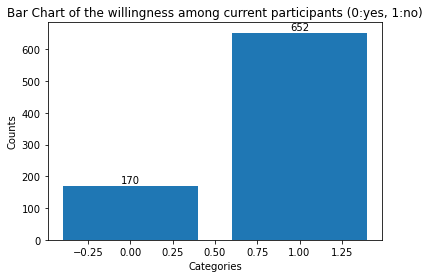

In [23]:
values = df[df['E1_3_1']==1]['E5'].value_counts()
labels = values.index
plt.figure(figsize=(6,4))
bars = plt.bar(labels, values)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')
plt.title('Bar Chart of the willingness among current participants (0:yes, 1:no)')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

822명 중 652명이 재참여 의사를 밝혔고, 170명이 재참여하지 않겠다고 했습니다. 그냥 스친 생각인데, 이런 데이터를 통해 노인일자리정책의 만족도를 계량할 수 있지 않나 생각도 드네요.

아무튼, 다시 본론으로 돌아와서, 우리는 처치집단과 통제집단을 아래와 같이 규정할 수 있습니다:

- Treated Group: 현재 노인일자리 정책에 참여 중인 집단.
- Controlled Group: 현재 노인일자리 정책에 참여하지 않고 있으나, 참여 의향이 있는 집단.

In [24]:
df_treated = df[df['E1_3_1']==1]
df_controlled = df_willing[df_willing['E1_3_1']==0]
df_combined = pd.concat([df_treated, df_controlled], ignore_index=True)

In [25]:
df_combined

,RES_AGE,RES_SEX,B1,B3,B4,B4_1_etc,B5_1_etc_1,B5_1_etc_2,B5_2_etc_1,B5_2_etc_2,...,D14_SUM,H3_SUM,H4_SUM,H13_SUM,H14_1_SUM,H16_SUM,E5,J3b_1_13,J3b_1_1,E1_3_1
0,67,2,2,2,1,1,0,0,0,0,...,0,30,17,0,0,18.28062,1,1789,1020,1
1,68,2,3,4,1,1,0,0,1,3,...,3,16,20,0,0,23.13697,1,719,324,1
2,79,2,2,1,1,1,0,0,0,0,...,0,20,15,0,0,21.00000,1,450,50,1
3,75,2,3,2,1,1,0,0,0,0,...,1,20,15,0,0,15.13697,1,655,270,1
4,69,2,1,0,0,0,0,0,0,0,...,0,15,13,0,0,12.13697,1,1505,810,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,65,2,3,0,0,0,0,0,0,0,...,0,18,17,0,0,19.13697,1,2045,1300,0
2259,66,2,1,0,0,0,0,0,0,0,...,1,18,19,0,0,18.13697,1,545,0,0
2260,67,2,3,1,1,2,0,0,0,0,...,3,14,15,0,0,14.00000,1,360,0,0
2261,70,2,2,2,1,3,0,0,0,0,...,3,15,13,0,0,14.00000,1,3200,0,0


# 3. Treatment Effect Measurement

Heterogeneous treatment effect를 파악하기 전에 treatment effect가 충분한지부터 파악해야합니다.

고로, 두 집단을 그룹한 후 그 차이를 확인해봅니다.

### 3.1. 우울증 척도 (높을수록 우울함)

처치/통제 집단의 우울증 척도를 살펴봅니다.

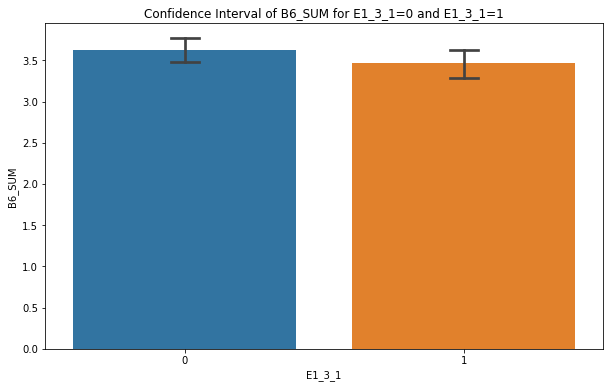

In [26]:
# Create a mask for your conditions
mask = df_combined['E1_3_1'].isin([0, 1])

# Create the plot for the subset of the dataframe
plt.figure(figsize=(10,6))
sns.barplot(x='E1_3_1', y='B6_SUM', data=df_combined[mask], ci=95, n_boot=1000, capsize=0.1)

plt.title('Confidence Interval of B6_SUM for E1_3_1=0 and E1_3_1=1')
plt.xlabel('E1_3_1')
plt.ylabel('B6_SUM')

plt.show()


In [15]:
# Separate the two groups
group_0 = df_combined[df_combined['E1_3_1'] == 0]['B6_SUM']
group_1 = df_combined[df_combined['E1_3_1'] == 1]['B6_SUM']

# Perform the t-test
t_stat, p_value = stats.ttest_ind(group_0, group_1)

print("t statistic: ", t_stat)
print("p-value: ", p_value)

# Set your significance level
alpha = 0.05

# Check if we deny H0
if p_value < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")


t statistic:  1.3364444277673804
p-value:  0.18153852516595217
We fail to reject the null hypothesis


### 3.2 근로소득

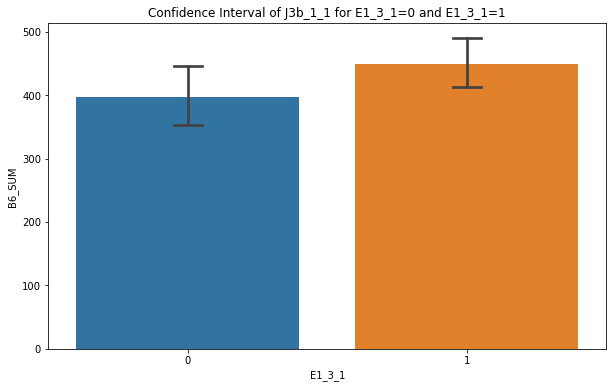

In [27]:
import matplotlib.pyplot as plt

# Create a mask for your conditions
mask = df_combined['E1_3_1'].isin([0, 1])

# Create the plot for the subset of the dataframe
plt.figure(figsize=(10,6))
sns.barplot(x='E1_3_1', y='J3b_1_1', data=df_combined[mask], ci=95, n_boot=1000, capsize=0.1)

plt.title('Confidence Interval of J3b_1_1 for E1_3_1=0 and E1_3_1=1')
plt.xlabel('E1_3_1')
plt.ylabel('B6_SUM')

plt.show()


In [39]:
# Separate the two groups
group_0 = df_combined[df_combined['E1_3_1'] == 0]['J3b_1_1']
group_1 = df_combined[df_combined['E1_3_1'] == 1]['J3b_1_1']

# Perform the t-test
t_stat, p_value = stats.ttest_ind(group_0, group_1)

print("t statistic: ", t_stat)
print("p-value: ", p_value)

# Set your significance level
alpha = 0.05

# Check if we deny H0
if p_value < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

t statistic:  -1.542202147474238
p-value:  0.12316441667944504
We fail to reject the null hypothesis


### 3.3. 본인 총수입액

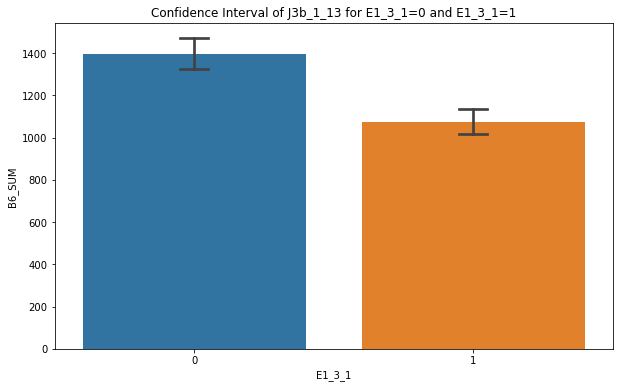

In [30]:
# Create a mask for your conditions
mask = df_combined['E1_3_1'].isin([0, 1])

# Create the plot for the subset of the dataframe
plt.figure(figsize=(10,6))
sns.barplot(x='E1_3_1', y='J3b_1_13', data=df_combined[mask], ci=95, n_boot=1000, capsize=0.1)

plt.title('Confidence Interval of J3b_1_13 for E1_3_1=0 and E1_3_1=1')
plt.xlabel('E1_3_1')
plt.ylabel('B6_SUM')

plt.show()


In [41]:
# Separate the two groups
group_0 = df_combined[df_combined['E1_3_1'] == 0]['J3b_1_13']
group_1 = df_combined[df_combined['E1_3_1'] == 1]['J3b_1_13']

# Perform the t-test
t_stat, p_value = stats.ttest_ind(group_0, group_1)

print("t statistic: ", t_stat)
print("p-value: ", p_value)

# Set your significance level
alpha = 0.05

# Check if we deny H0
if p_value < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

t statistic:  5.7240258592947475
p-value:  1.178411957861232e-08
We reject the null hypothesis


In [32]:
# Separate the two groups
group_0 = df_combined[df_combined['E1_3_1'] == 0]
group_1 = df_combined[df_combined['E1_3_1'] == 1]

# Set your significance level
alpha = 0.05

# List to store columns that deny H0
columns_deny_H0 = []

# Iterate over each column in the group dataframes
for column in df_combined.columns:
    if df_combined[column].dtype in [np.int64, np.float64] and column != 'E1_3_1':
        # Perform the t-test
        t_stat, p_value = stats.ttest_ind(group_0[column], group_1[column], nan_policy='omit')
        # Check if we deny H0
        if p_value < alpha:
            columns_deny_H0.append(column)

# Print the columns that deny H0
print("Columns that deny the null hypothesis: ", columns_deny_H0)


Columns that deny the null hypothesis:  ['RES_AGE', 'RES_SEX', 'B4', 'B5_2_etc_1', 'B8', 'B8_1a', 'B9', 'I1x1', 'B2_2L_23', 'B2_2L_30', 'B2_2L_32', 'B6_1', 'B6_5', 'B6_7', 'B6_11', 'B6_13', 'B9_1a', 'B9_2a', 'B10_1', 'B10_3', 'B11_1', 'B11_2', 'B11_3_2', 'B11_3_3', 'B11_5', 'B11_6', 'B11_7', 'B11_9', 'C2_1', 'C2_2', 'C5_1', 'C5_2', 'C5_3', 'C5_4', 'C6_2', 'C6_3', 'C6_4', 'C6_5', 'C7_1_2', 'C7_1_3', 'C7_1_4', 'C7_1_5', 'C7_1_7', 'C7_2_10', 'B2_3', 'B9_3a', 'B10_BMI', 'B11_SUM', 'C_SUM_1', 'C5_SUM', 'C_6_7_SUM', 'S5_1', 'S5_2', 'S6_1', 'S6_2', 'S6_3', 'S6_4', 'S6_5', 'F1_1_2_1', 'F1_1_2_2', 'F1_1_3_2', 'F2_1', 'F5_1_etc', 'G4_1', 'F13_1_etc', 'F14', 'F14_1', 'F15', 'F16_1', 'AREA_11', 'AREA_21', 'AREA_24', 'AREA_26', 'AREA_29', 'AREA_32', 'AREA_33', 'AREA_35', 'AREA_36', 'AREA_37', 'AREA_38', 'G1_4_7', 'G1_4_9', 'G1_4_11', 'G2_4_8', 'G2_4_11', 'G1_4_AGG', 'G2_4_AGG', 'D1_1_etc', 'D2', 'D3', 'H1_5', 'H11', 'H15', 'D11_2_1', 'D11_2_2', 'D11_2_4', 'D13_1', 'D13_2', 'D13_3', 'D13_4', 'D13_5'

# 4. Causal Forest

그 다음은 causal forest 모델을 돌립니다. X, T, Y는 다음과 같습니다:

- X: 각종 features
- T: 노인일자리 참여 참여여부
- Y: 본인 총수입액 (J3b_1_13)
    
*Note: X와 Y의 선정은 추후에 많이 달라질 것임.*

In [57]:
X = df[health_essential+health_compound+social_essential+social_compound+life_essential+life_compound]
Y = df['J3b_1_13'].values
T = df['E1_3_1'].values

# Define some parameters
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.05

est = CausalForestDML(model_y=WeightedLassoCVWrapper(cv=3),
                       model_t=WeightedLassoCVWrapper(cv=3),
                       n_estimators=n_trees, min_samples_leaf=min_leaf_size, max_depth=max_depth,
                       max_samples=subsample_ratio/2,
                       random_state=123)
est.fit(Y, T, X=X, W=X)
treatment_effects = est.effect(X)
te_lower, te_upper = est.effect_interval(X)
shap_values = est.shap_values(X)

 99%|===================| 9850/9920 [00:55<00:00]        

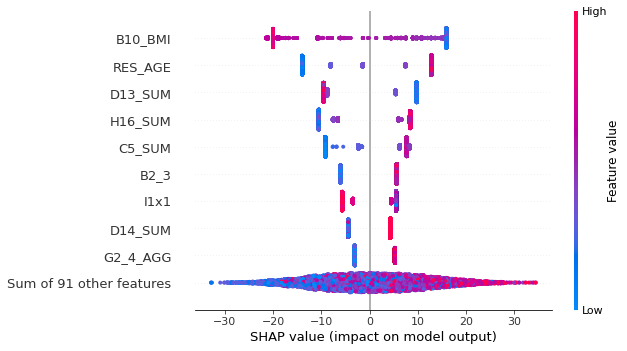

In [58]:
shap.plots.beeswarm(shap_values['Y0']['T0'])

In [59]:
X = df[health_essential+health_compound+social_essential+social_compound+life_essential+life_compound]
Y = df['J3b_1_13'].values
T = df['E1_3_1'].values

# Define some parameters
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.15

est = CausalForestDML(model_y=WeightedLassoCVWrapper(cv=3),
                       model_t=WeightedLassoCVWrapper(cv=3),
                       n_estimators=n_trees, min_samples_leaf=min_leaf_size, max_depth=max_depth,
                       max_samples=subsample_ratio/2,
                       random_state=123)
est.fit(Y, T, X=X, W=X)
treatment_effects = est.effect(X)
te_lower, te_upper = est.effect_interval(X)
shap_values = est.shap_values(X)

100%|===================| 9910/9920 [03:05<00:00]        

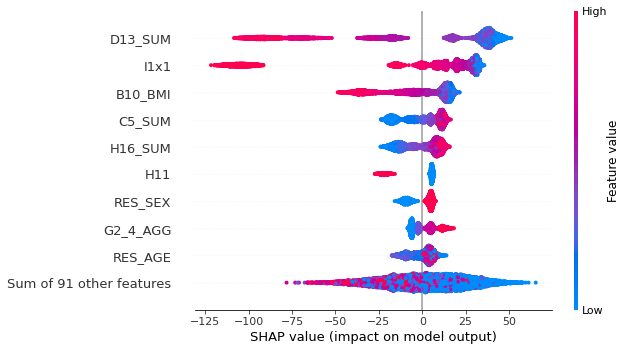

In [60]:
shap.plots.beeswarm(shap_values['Y0']['T0'])

In [79]:
X = df[health_essential+health_compound+social_essential+social_compound+life_essential+life_compound]
Y = df['J3b_1_13'].values
T = df['E1_3_1'].values

# Define some parameters
n_trees = 1000
min_leaf_size = 5
max_depth = 20
subsample_ratio = 0.05

est = CausalForestDML(model_y=WeightedLassoCVWrapper(cv=3),
                       model_t=WeightedLassoCVWrapper(cv=3),
                       n_estimators=n_trees, min_samples_leaf=min_leaf_size, max_depth=max_depth,
                       max_samples=subsample_ratio/2,
                       random_state=123)
est.fit(Y, T, X=X, W=X)
treatment_effects = est.effect(X)
te_lower, te_upper = est.effect_interval(X)
shap_values = est.shap_values(X)

100%|===================| 9919/9920 [18:44<00:00]        

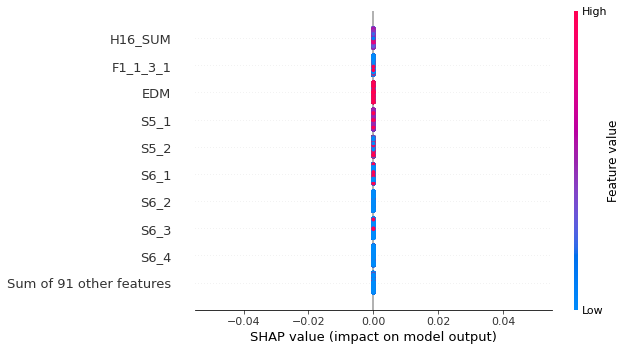

In [62]:
shap.plots.beeswarm(shap_values['Y0']['T0'])

In [63]:
X = df_combined[health_essential+health_compound+social_essential+social_compound+life_essential+life_compound]
Y = df_combined['J3b_1_13'].values
T = df_combined['E1_3_1'].values

# Define some parameters
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.3

est = CausalForestDML(model_y=WeightedLassoCVWrapper(cv=3),
                       model_t=WeightedLassoCVWrapper(cv=3),
                       n_estimators=n_trees, min_samples_leaf=min_leaf_size, max_depth=max_depth,
                       max_samples=subsample_ratio/2,
                       random_state=123)
est.fit(Y, T, X=X, W=X)
treatment_effects = est.effect(X)
te_lower, te_upper = est.effect_interval(X)
shap_values = est.shap_values(X)

 98%|===================| 2227/2263 [00:17<00:00]        

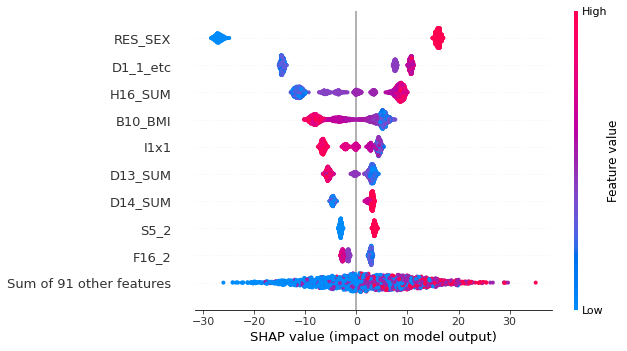

In [64]:
shap.plots.beeswarm(shap_values['Y0']['T0'])

In [65]:
X = df_combined[health_essential+health_compound+social_essential+social_compound+life_essential+life_compound]
Y = df_combined['J3b_1_13'].values
T = df_combined['E1_3_1'].values

# Define some parameters
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.05

est = CausalForestDML(model_y=WeightedLassoCVWrapper(cv=3),
                       model_t=WeightedLassoCVWrapper(cv=3),
                       n_estimators=n_trees, min_samples_leaf=min_leaf_size, max_depth=max_depth,
                       max_samples=subsample_ratio/2,
                       random_state=123)
est.fit(Y, T, X=X, W=X)
treatment_effects = est.effect(X)
te_lower, te_upper = est.effect_interval(X)
shap_values = est.shap_values(X)

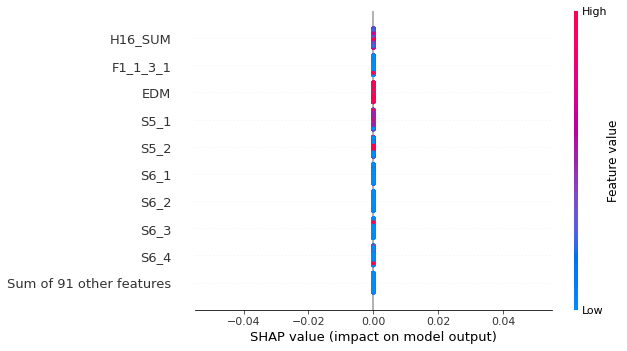

In [66]:
shap.plots.beeswarm(shap_values['Y0']['T0'])

In [67]:
X = df_combined[health_essential+health_compound+social_essential+social_compound+life_essential+life_compound]
Y = df_combined['J3b_1_13'].values
T = df_combined['E1_3_1'].values

# Define some parameters
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.5

est = CausalForestDML(model_y=WeightedLassoCVWrapper(cv=3),
                       model_t=WeightedLassoCVWrapper(cv=3),
                       n_estimators=n_trees, min_samples_leaf=min_leaf_size, max_depth=max_depth,
                       max_samples=subsample_ratio/2,
                       random_state=123)
est.fit(Y, T, X=X, W=X)
treatment_effects = est.effect(X)
te_lower, te_upper = est.effect_interval(X)
shap_values = est.shap_values(X)

 98%|===================| 2223/2263 [00:29<00:00]        

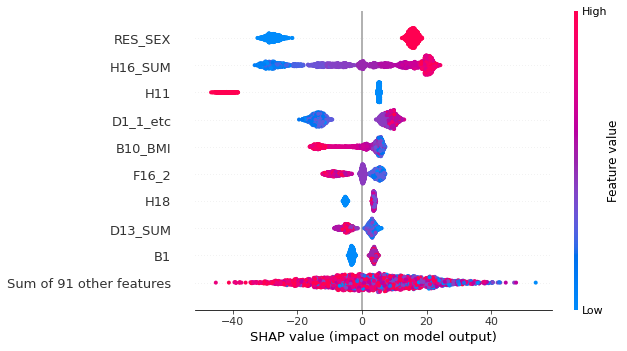

In [68]:
shap.plots.beeswarm(shap_values['Y0']['T0'])

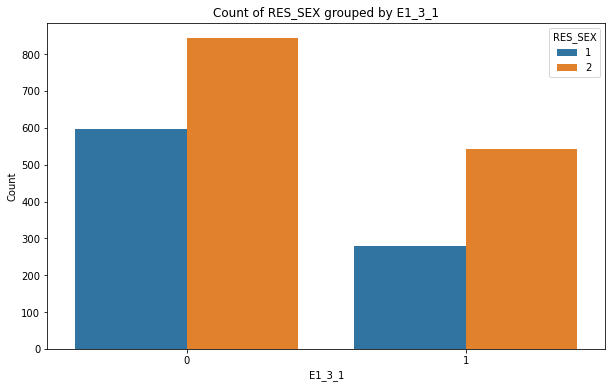

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the plot
sns.countplot(x='E1_3_1', hue='RES_SEX', data=df_combined)

# Set the title and labels
plt.title('Count of RES_SEX grouped by E1_3_1')
plt.xlabel('E1_3_1')
plt.ylabel('Count')

# Show the plot
plt.show()


두 번 정도만 해보면 되지 않을까. 

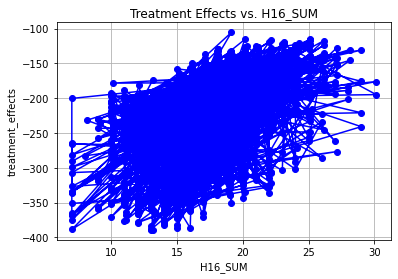

In [75]:
plt.plot(df_combined['H16_SUM'], treatment_effects, marker='o', linestyle='-', color='b')
plt.xlabel('H16_SUM')
plt.ylabel('treatment_effects')
plt.title('Treatment Effects vs. H16_SUM')
plt.grid(True)
plt.show()

What if I plot the CI interval grouped by the value of H16_SUM values? (about 30 values in total)

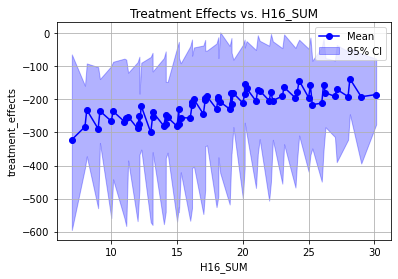

In [78]:
df_plot = pd.DataFrame({
    'H16_SUM': df_combined['H16_SUM'],
    'treatment_effects': treatment_effects,
    'te_lower': te_lower,
    'te_upper': te_upper
})

# Group the data by H16_SUM and calculate the mean and 95% CI for each group
grouped_data = df_plot.groupby('H16_SUM').agg({
    'treatment_effects': 'mean',
    'te_lower': lambda x: x.quantile(0.025),  # 2.5th percentile for 95% CI
    'te_upper': lambda x: x.quantile(0.975)   # 97.5th percentile for 95% CI
}).reset_index()

# Plotting the data with continuous lines representing the mean and filled areas for the 95% CI bands
plt.plot(grouped_data['H16_SUM'], grouped_data['treatment_effects'], marker='o', color='b', label='Mean')
plt.fill_between(grouped_data['H16_SUM'], grouped_data['te_lower'], grouped_data['te_upper'],
                 color='b', alpha=0.3, label='95% CI')

plt.xlabel('H16_SUM')
plt.ylabel('treatment_effects')
plt.title('Treatment Effects vs. H16_SUM')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
데이터 갯수:
    511690
    5735
    85440
    20000
    10000


In [48]:
treatment_effects.shape

(9920,)

In [49]:
df_combined['D13_SUM']

0        9.0
1        2.0
2        7.0
3        0.0
4       10.0
        ... 
2258     4.0
2259     8.0
2260     7.0
2261     6.0
2262     3.0
Name: D13_SUM, Length: 2263, dtype: float64

In [98]:
import shap

In [140]:
from xgboost import XGBRegressor

# Prepare data
X = df[health_essential+health_compound+social_essential+social_compound+life_essential+life_compound]
Y = df['J3b_1_13'].values
T = df['E1_3_1'].values

n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.04

xgb_reg = XGBRegressor(objective ='reg:squarederror', n_estimators=100, learning_rate=0.1)

est2 = CausalForestDML(model_y=xgb_reg,
                       model_t=xgb_reg,
                       n_estimators=n_trees, min_samples_leaf=min_leaf_size, max_depth=max_depth,
                       max_samples=subsample_ratio/2,
                       random_state=123)

est2.fit(Y, T, X=X, W=X)
treatment_effects2 = est2.effect(X.values.reshape(-1, 1))
te_lower2, te_upper2 = est2.effect_interval(X.values.reshape(-1, 1))


AssertionError: Dimension mis-match of X with fitted X

In [134]:
shap_values = est2.shap_values(W)

 94%|=================== | 9372/9920 [00:11<00:00]       

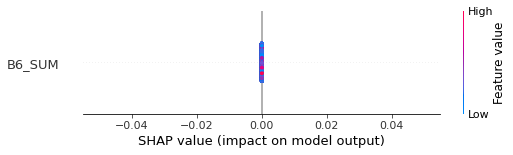

In [135]:
shap.plots.beeswarm(shap_values['Y0']['T0'])

In [130]:
treatment_effects2

i have a 2d array named treatmnet_effects2. I want to 

array([[-339.45138416],
       [-339.45138416],
       [-339.45138416],
       ...,
       [-339.45138416],
       [-339.45138416],
       [-339.45138416]])

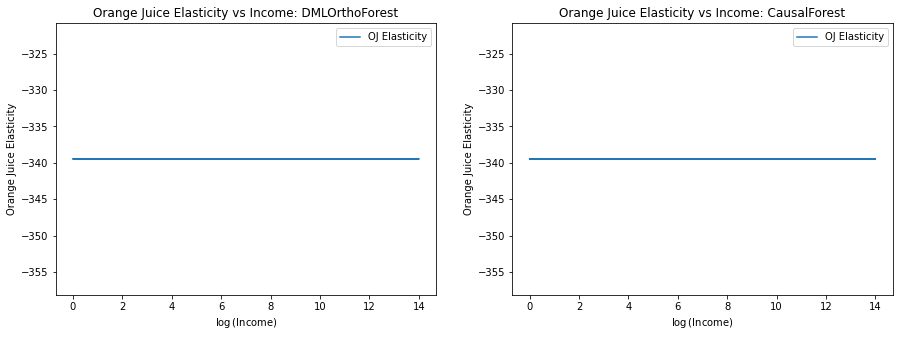

In [132]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X.values.flatten(), treatment_effects2, label="OJ Elasticity")
# plt.fill_between(X.values.flatten(), te_lower2, te_upper2, label="95% BLB CI", alpha=0.3)
plt.xlabel(r'$\log$(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income: DMLOrthoForest")
plt.subplot(1, 2, 2)
plt.plot(X.values.flatten(), treatment_effects2, label="OJ Elasticity")
# plt.fill_between(X.values.flatten(), te_lower2, te_upper2, label="95% BLB CI", alpha=0.3)
plt.xlabel(r'$\log$(Income)')
plt.ylabel('Orange Juice Elasticity')
plt.legend()
plt.title("Orange Juice Elasticity vs Income: CausalForest")
plt.show()


In [107]:
X = df['B6_SUM'].values
X

array([ 2,  2,  4, ...,  7, 11,  4])

# 2. Propensity Score Matching

In [ ]:
# Main imports
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV

# Helper imports
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt
import shap

%matplotlib inline

# Define some parameters
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.04

est2 = CausalForestDML(model_y=WeightedLassoCVWrapper(cv=3),
                       model_t=WeightedLassoCVWrapper(cv=3),
                       n_estimators=n_trees, min_samples_leaf=min_leaf_size, max_depth=max_depth,
                       max_samples=subsample_ratio/2,
                       random_state=123)
est2.fit(Y, T, X=X, W=X)
treatment_effects2 = est2.effect(X)
te_lower2, te_upper2 = est2.effect_interval(X)
shap_values = est2.shap_values(X)

In [ ]:
shap.summary_plot(shap_values, X)


그 다음은 Propensity Score Matching을 시작합니다.

In [9]:
df.groupby('E1_3_1').mean()

,RES_AGE,RES_SEX,B1,B3,B4,B4_1_etc,B5_1_etc_1,B5_1_etc_2,B5_2_etc_1,B5_2_etc_2,...,D7_3_3,D11_2_SUM,D13_SUM,D14_SUM,H3_SUM,H4_SUM,H13_SUM,H14_1_SUM,H16_SUM,propensity_score
E1_3_1,,,,,,,,,,,,,,,,,,,,,
0,73.334909,1.594197,2.671576,1.780611,0.680149,1.490987,0.002198,0.111233,0.162124,1.170367,...,0.158826,1.289954,3.722871,1.950868,19.686305,16.156848,0.050231,0.054078,17.19365,0.080624
1,74.582725,1.660584,2.605839,1.672749,0.779805,1.673966,0.006083,0.017032,0.431873,1.394161,...,0.328467,2.093674,3.168559,2.148418,19.451338,15.987835,0.051095,0.226277,17.22983,0.209124


In [21]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.neighbors import NearestNeighbors

# Load your covariates
covariates = health_essential + health_compound + social_essential + social_compound

# Separate features and target
X = df[covariates]
y = df['E1_3_1']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train XGBoost model
model = XGBClassifier()
model.fit(X_train, y_train)

# Calculate propensity scores
train_preds = model.predict_proba(X_train)[:,1]
test_preds = model.predict_proba(X_test)[:,1]

# Scale propensity scores to 0-1 range
scaler = MinMaxScaler()
train_preds = scaler.fit_transform(train_preds.reshape(-1, 1))
test_preds = scaler.transform(test_preds.reshape(-1, 1))

# Add propensity scores back into dataframe
df.loc[X_train.index, 'propensity_score'] = train_preds
df.loc[X_test.index, 'propensity_score'] = test_preds

# Separate treatment and control groups
treatment = df[df['E1_3_1'] == 1]
control = df[df['E1_3_1'] == 0]

# # One-to-one matching
# neigh = NearestNeighbors(n_neighbors=1)
# neigh.fit(control['propensity_score'].values.reshape(-1, 1))

# distances, indices = neigh.kneighbors(treatment['propensity_score'].values.reshape(-1, 1))

# matched = control.iloc[indices.reshape(-1)]

# # Now, 'treatment' and 'matched' dataframes contain the treatment group and matched control group respectively

# Fit nearest neighbors model
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(np.array(control['propensity_score']).reshape(-1, 1))

matched_indices = []
control_indices = list(control.index)

for treated_index in treatment.index:
    treated_ps = treatment.loc[treated_index, 'propensity_score']
    distance, index = neigh.kneighbors(np.array([treated_ps]).reshape(1, -1))
    matched_index = control_indices[index[0][0]]
    
    # Add matched index to list
    matched_indices.append(matched_index)
    
    # Remove matched index from available control indices and from nearest neighbors model
    control_indices.remove(matched_index)
    neigh.fit(np.array(control.loc[control_indices, 'propensity_score']).reshape(-1, 1))

# Now you have unique control units for each treated unit
matched = control.loc[matched_indices]


In [22]:
matched[['E1_3_1','propensity_score']]

,E1_3_1,propensity_score
4730,0,0.774777
5050,0,0.742393
5266,0,0.730081
2602,0,0.715446
7419,0,0.676843
...,...,...
4624,0,0.079099
1833,0,0.070878
9660,0,0.078892
148,0,0.078593


문제: 1. 포인트 중복사용 과다

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

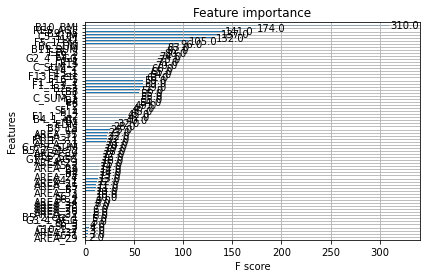

In [24]:
xgb.plot_importance(model)

In [26]:
# Get feature importances
importance_dict = model.get_booster().get_score(importance_type='weight')

# Convert dictionary to dataframe
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
})

# Sort dataframe by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
18,B10_BMI,310.0
0,RES_AGE,174.0
17,B9_3a,141.0
22,C5_SUM,137.0
14,I1x1,132.0
...,...,...
13,C10_1_2,4.0
29,S6_3,4.0
64,AREA_37,3.0
27,S6_1,3.0


In [5]:
# Load your data
# df = pd.read_csv("your_data.csv")

# Define your models
models = {
    "xgboost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "random_forest": RandomForestClassifier()
}

# Define different combinations of covariates
covariate_sets = [

    health_essential + health_compound,
    health_essential + health_raw,
    social_essential + social_compound,
    social_essential + social_raw,
    life_essential + life_compound,
    life_essential + life_raw,
    health_essential + health_compound + social_essential + social_compound,
    social_essential + social_compound + life_essential + life_compound,
    health_essential + health_compound + life_essential + life_compound,
    health_essential + health_compound + social_essential + social_compound + life_essential + life_compound
    
    # Add more if needed
]

# Set up cross-validation
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Placeholder for results
results = []

# For each model and each set of covariates
for model_name, model in models.items():
    for covariates in covariate_sets:
        # Estimate propensity scores with cross-validation
        treatment = df['E1_3_1']
#         outcome = df['outcome']
        covariate_data = df[covariates]
        propensity_scores = np.zeros(len(treatment))
        for train_index, test_index in kfold.split(covariate_data, treatment):
            X_train, X_test = covariate_data.iloc[train_index], covariate_data.iloc[test_index]
            y_train, y_test = treatment.iloc[train_index], treatment.iloc[test_index]
            model.fit(X_train, y_train)
            propensity_scores[test_index] = model.predict_proba(X_test)[:,1]

        # Match on propensity scores
        df['propensity_score'] = propensity_scores
        treated = df[df['E1_3_1'] == 1]
        untreated = df[df['E1_3_1'] == 0]
        nbrs = NearestNeighbors(n_neighbors=len(untreated), algorithm='ball_tree').fit(untreated['propensity_score'].values.reshape(-1,1))
        distances, indices = nbrs.kneighbors(treated['propensity_score'].values.reshape(-1,1))

        matched_indices = []
        for index_set in indices:
            for index in index_set:
                if index not in matched_indices:
                    matched_indices.append(index)
                    break

        matches = treated.assign(match=matched_indices).reset_index(drop=True)
        matches = pd.concat([matches, untreated.reset_index(drop=True).loc[matches['match']]], axis=1)


        # Calculate maximum standardized mean difference
        covariate_differences = matches[covariates].iloc[:, :len(covariates)] - matches[covariates].iloc[:, len(covariates):]
        covariate_standard_deviation = covariate_differences.std()
        covariate_mean_difference = covariate_differences.mean()
        standardized_mean_differences = (covariate_mean_difference / covariate_standard_deviation).abs()
        max_smd = standardized_mean_differences.max()

        # Save results
        results.append({
            "model": model_name,
            "covariates": covariates,
            "max_smd": max_smd
        })

# Find the model and covariate set with the lowest error
best_result = min(results, key=lambda x: x["max_smd"])
print(f"Best model: {best_result['model']} with covariates {best_result['covariates']}. Max SMD: {best_result['max_smd']}")


/Users/gimmin-u/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Best model: xgboost with covariates ['RES_AGE', 'RES_SEX', 'B1', 'B3', 'B4', 'B4_1_etc', 'B5_1_etc_1', 'B5_1_etc_2', 'B5_2_etc_1', 'B5_2_etc_2', 'B7', 'B8', 'B8_1a', 'B9', 'C4', 'C10_1_2', 'I1x1', 'B2_3', 'B6_SUM', 'B9_3a', 'B10_BMI', 'B11_SUM', 'C_SUM_1', 'C_SUM_2', 'C5_SUM', 'C_6_7_SUM']. Max SMD: nan


In [6]:
matches

,RES_AGE,RES_SEX,B1,B3,B4,B4_1_etc,B5_1_etc_1,B5_1_etc_2,B5_2_etc_1,B5_2_etc_2,...,D11_2_SUM,D13_SUM,D14_SUM,H3_SUM,H4_SUM,H13_SUM,H14_1_SUM,H16_SUM,E1_3_1,propensity_score
0,67.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,68.0,2.0,3.0,4.0,1.0,1.0,0.0,0.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,79.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75.0,2.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,69.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,2.000000,3.0,20.0,11.0,0.0,0.0,14.00000,0.0,0.01
1335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.000000,3.0,20.0,18.0,0.0,0.0,15.13697,0.0,0.11
1713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,1.000000,3.0,22.0,13.0,0.0,0.0,17.00000,0.0,0.11
3960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,3.676939,0.0,16.0,14.0,0.0,0.0,14.00000,0.0,0.04


In [33]:
len(life_compound)

10